# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» (название вымышленное) внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В моём распоряжении набор фотографий людей с указанием возраста.

Изучим имеющиеся данные и попытаемся построить модель компьютерного зрения для решения поставленной задачи.

Задачи:
- Провести исследовательский анализ набора фотографий.
- Подготовить данные к обучению.
- Обучить нейронную сеть и рассчитать её качество.
- Значение метрики **MAE** не должно быть выше значения: 8.

*Примечание:* Обучение нейронной сети выполнялось на GPU-процессорах. В тетради продемонстрирован код сборки нейронной сети, процесс и результаты обучения.

**Описание данных**

Данные взяты с сайта [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/).
В моём распоряжении папка с изображениями. И csv-файл: `labels.csv`, с двумя колонками: `file_name` и `real_age`. 

## Исследовательский анализ данных

Импортируем необходимые библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузим данные и выведем их на экран

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255.)

train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels, directory='/datasets/faces/final_files/',
    x_col='file_name', y_col='real_age',
    target_size=(224, 224), batch_size=32,
    class_mode='raw', seed=555)

Found 7591 validated image filenames.


У нас имеется выборка в размере 75981 изображение.

Посмотрим на таблицу с целевыми признаками:

In [ ]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Данные выглядят корректно, типы данных соответствуют содержанию, пропусков не наблюдается.

Построим распределение возрастов:

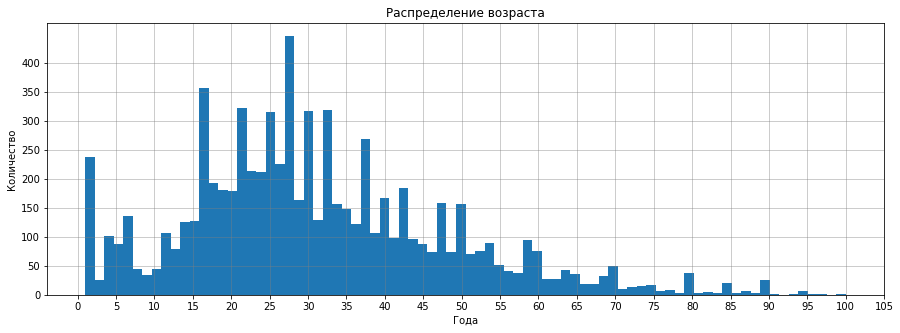

In [ ]:
plt.figure(figsize=(15, 5))
labels.real_age.plot(kind='hist', bins=80, title='Age')
plt.title(f'Распределение возраста')
plt.ylabel('Количество')
plt.xlabel('Года')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.xticks(np.arange(0, 110, 5))
plt.yticks(np.arange(0, 450, 50))
plt.show()

Распределение выглядит нормальным, выбросов не наблюдается. При этом заметно количество детей около 3 лет.

Посмотрим на фотографии

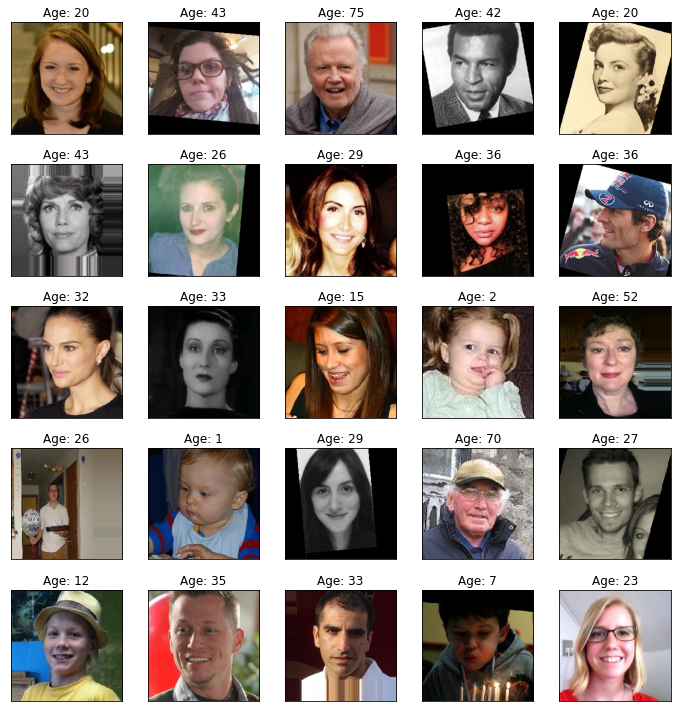

In [ ]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10, 10))
for i in range(25):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.title('Age: {}'.format(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Фотографии из датасета выглядит корректно для оубчения.

## Обучение модели

```python

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255.,
        horizontal_flip=True)
    train_data = train_datagen.flow_from_dataframe(
        dataframe=labels, directory=path + 'final_files/',
        x_col='file_name', y_col='real_age',
        target_size=(224, 224), batch_size=16,
        class_mode='raw', subset='training', seed=555)

    return train_data

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255.)
    test_data = test_datagen.flow_from_dataframe(
        dataframe=labels, directory=path + 'final_files/',
        x_col='file_name', y_col='real_age',
        target_size=(224, 224), batch_size=16,
        class_mode='raw', subset='validation', seed=555)

    return test_data

def create_model(input_shape):
    model = Sequential()
    optimizer = Adam(lr=0.0001)

    beckbone = ResNet50(input_shape=input_shape, weights='imagenet',
                    include_top=False)
    model.add(beckbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer,
                  loss='mse', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
          validation_data=test_data,
          epochs=epochs, 
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps, 
          verbose=2,
          shuffle=True)
    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps
Epoch 1/10

356/356 - 49s - loss: 213.0215 - mae: 10.5423 - val_loss: 839.6384 - val_mae: 24.0654
Epoch 2/10
356/356 - 39s - loss: 86.9603 - mae: 7.0735 - val_loss: 140.8363 - val_mae: 8.9016
Epoch 3/10
356/356 - 39s - loss: 54.7496 - mae: 5.6744 - val_loss: 86.3062 - val_mae: 6.9560
Epoch 4/10
356/356 - 39s - loss: 40.1855 - mae: 4.8400 - val_loss: 80.2024 - val_mae: 6.6548
Epoch 5/10
356/356 - 39s - loss: 31.3510 - mae: 4.3043 - val_loss: 70.2723 - val_mae: 6.2094
Epoch 6/10
356/356 - 39s - loss: 27.0891 - mae: 3.9591 - val_loss: 108.5513 - val_mae: 8.2622
Epoch 7/10
356/356 - 39s - loss: 21.1060 - mae: 3.5465 - val_loss: 70.2048 - val_mae: 6.1423
Epoch 8/10
356/356 - 39s - loss: 17.5808 - mae: 3.1771 - val_loss: 70.7068 - val_mae: 6.2188
Epoch 9/10
356/356 - 39s - loss: 14.4537 - mae: 2.9115 - val_loss: 64.9171 - val_mae: 5.9966
Epoch 10/10
356/356 - 39s - loss: 13.9985 - mae: 2.8500 - val_loss: 71.7160 - val_mae: 6.5009

119/119 - 10s - loss: 71.7160 - mae: 6.5009
Test MAE: 6.5009

```

## Анализ обученной модели

Результат обучения модели на 10-и эпохах:
- МАЕ на обучающей выборке: 2.85;
- МАЕ на тестовой выборке: 6.50.

Целевая метрика достигнута.